Este notebook contém uma análise de exames relacionados a FUNGOS e BACTÉRIAS da base de dados do Hospital Sírio Libanês (HSL) disponível em [FAPESP COVID-19 Data Sharing/BR](https://repositoriodatasharingfapesp.uspdigital.usp.br/)



In [ ]:
# Última modificação: 22/02/2024

In [ ]:
#Bibliotecas e instalações
import numpy as np
import pandas as pd
from pandas import DataFrame
import csv
from numpy import mean
from numpy import std
from numpy import correlate
from numpy.random import randn
from numpy.random import seed
import matplotlib.pyplot as plt
#plt.style.use('default')
#%matplotlib inline
import seaborn as sns
#import pandas_profiling
#from google.colab import files
import seaborn as sns
import warnings
import datetime as dt
from datetime import date
import os
!pip install 'openpyxl>=3.0.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  # 1.0 - INTEGRAÇÃO DE DADOS





















In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [ ]:
# Verifica a existência do arquivo e, se necessário, vai para o diretório correto
verifica_arquivo = os.path.exists("Datasets")
if verifica_arquivo == False:
    %cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao

# arquivo "HSL_Pacientes_3.csv" referente a janeiro 2021
df_pacientes = pd.read_csv('Datasets/HSL_Pacientes_3.csv', sep='|')
print("df_pacientes...............: ", df_pacientes.shape)

#verificando a existência de valores duplicatos
df_pacientes = df_pacientes.drop_duplicates()
print("df_pacientes sem duplicatos: ", df_pacientes.shape, "\n")

# arquivo "HSL_Exames_3.csv" 
df_exames = pd.read_csv('Datasets/HSL_Exames_3.csv', sep='|')
print("df_exames..................: ", df_exames.shape)

#Eliminando exemplos repetidos
df_exames = df_exames.drop_duplicates()
print("df_exames sem duplicatos...: ", df_exames.shape, "\n")

# Criando coluna Exame.Analito
df_exames["Exame.Analito"] = df_exames["DE_EXAME"]+"."+df_exames["DE_ANALITO"]

# arquivo "HSL_Desfechos_3.csv"
df_desfecho = pd.read_csv('Datasets/HSL_Desfechos_3.csv', sep='|')
print("df_desfecho................: ", df_desfecho.shape)

#Eliminando exemplos repetidos
df_desfecho = df_desfecho.drop_duplicates()
print("df_desfecho em duplicatos..: ", df_desfecho.shape)

#adiciona colunas do dataset 'desfecho' na frente dos repectivos id_paciente e id_atendimento iguais
df_sirio = df_exames.merge(df_desfecho, on = ["ID_PACIENTE", "ID_ATENDIMENTO"], how = "left")
print("\ndf_sirio...................: ", df_sirio.shape)

# Obtendo SEXO e Ano de nascimento da planilha HSL_PACIENTES
pacientes_2 = df_pacientes[['ID_PACIENTE','aa_nascimento','IC_SEXO']]

#adiciona a coluna aa_nacimento do dataframe pacientes em sirio
df_sirio = df_sirio.merge(pacientes_2, on=['ID_PACIENTE'], how='left')
print("Pacientes únicos...........: ", df_sirio["ID_PACIENTE"].nunique(), '\n')

# Cria coluna Exame.Analito
df_sirio["Exame.Analito"] = df_sirio["DE_EXAME"]+"."+df_sirio["DE_ANALITO"]

df_sirio.columns

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao
df_pacientes...............:  (8971, 7)
df_pacientes sem duplicatos:  (8971, 7) 

df_exames..................:  (1463834, 9)
df_exames sem duplicatos...:  (1436537, 9) 

df_desfecho................:  (42691, 8)
df_desfecho em duplicatos..:  (42691, 8)

df_sirio...................:  (1436537, 16)
Pacientes únicos...........:  8971 



Index(['ID_PACIENTE', 'ID_ATENDIMENTO', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME',
       'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA',
       'Exame.Analito', 'DT_ATENDIMENTO', 'DE_TIPO_ATENDIMENTO', 'ID_CLINICA',
       'DE_CLINICA', 'DT_DESFECHO', 'DE_DESFECHO', 'aa_nascimento', 'IC_SEXO'],
      dtype='object')

## Analisando desfecho 

In [ ]:
df_desfecho['DE_DESFECHO'].value_counts()

Alta Administrativa                                                 29613
Alta médica melhorado                                               12277
Desistência do atendimento                                            229
Alta a pedido                                                         210
Alta médica Inalterado                                                145
Óbito após 48hs de internação sem necrópsia                            78
Alta médica curado                                                     61
Alta por abandono                                                      39
Transferência Inter-Hospitalar Externa - Serviço de Ambulância         15
Óbito nas primeiras 48hs de internação sem necrópsia não agônico       13
Assistência Domiciliar                                                  7
Transferência Inter-Hospitalar Externa - Transporte Próprio             2
Óbito após 48hs de internação com necrópsia                             1
Óbito nas primeiras 48hs de internação

In [ ]:
df_desfecho.head(3)

,ID_PACIENTE,ID_ATENDIMENTO,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO
0,EAADD95C88D58DDAAA38953C8E49DD6C,03F7868BD8361515CC9AA4C7A175962A,30/11/2020,Ambulatorial,11,Consulta,30/11/2020,Alta a pedido
1,B5A04CD819AD85BDA8D688A5F7CAF4E5,FB5A9F180E5C1B7136E13D1C9C4F7A98,22/10/2020,Pronto Atendimento,42,CL Médica Síndromes Virais,22/10/2020,Alta a pedido
2,5E737D6235A9464E7D0E0AB21FCD4DA9,359CA9140E2A478FB7ED4D782F339BF9,21/07/2020,Pronto Atendimento,42,CL Médica Síndromes Virais,21/07/2020,Alta a pedido


In [ ]:
grupos = df_desfecho.groupby(["ID_PACIENTE"]).agg( {"DE_DESFECHO" :['last']}).reset_index()

#solucionando nome colunas dois niveis
grupos.columns = [ '_'.join(x) for x in grupos.columns ]
grupos.columns=['PACIENTE', 'DESFECHO']

grupos["DESFECHO"].value_counts()

# 90 óbitos


Alta Administrativa                                                 5709
Alta médica melhorado                                               2735
Desistência do atendimento                                           209
Alta a pedido                                                         78
Óbito após 48hs de internação sem necrópsia                           76
Alta médica Inalterado                                                70
Alta por abandono                                                     17
Óbito nas primeiras 48hs de internação sem necrópsia não agônico      12
Transferência Inter-Hospitalar Externa - Serviço de Ambulância         8
Alta médica curado                                                     7
Assistência Domiciliar                                                 4
Óbito após 48hs de internação com necrópsia                            1
Transferência Inter-Hospitalar Externa - Transporte Próprio            1
Óbito nas primeiras 48hs de internação sem necrópsi

In [ ]:
inform_desfecho = df_desfecho[["ID_PACIENTE", "DE_DESFECHO"]]

inform_desfecho.shape

(42691, 2)

# 2.0 - PERÍODO DE REALIZAÇÃO DOS EXAMES




In [ ]:
df2 = df_sirio.copy(deep=True)

# Formato data to datetime
df2['DT_ATENDIMENTO'] = pd.to_datetime(df2['DT_ATENDIMENTO'])
df2['DT_COLETA'] = pd.to_datetime(df2['DT_COLETA'])
df2['DT_DESFECHO'] = pd.to_datetime(df2['DT_COLETA'])

# Período exames
df2['PERIODO_EXAMES'] = (df2['DT_COLETA']-df2['DT_ATENDIMENTO']).dt.days
print(df2.shape, '\n')

# Elimina exames que possuam período < 0
df2 = df2[ df2["PERIODO_EXAMES"] >= 0 ]
print(df2.shape, '\n')


(1436537, 19) 

(1101888, 19) 



# 3.0 - CRITÉRIOS DE EXCLUSÃO DE PACIENTES

## Permanecem apenas pacientes contidos na lista de COVID-19 positivo

In [ ]:
# Acessa diretório correto
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

# Importa lista de planilha exportada anteriormente
df_pacientes_positivos = pd.read_excel('lista_covid_positivo.xlsx', sheet_name='Sheet1')

# Transforma coluna do dataframe Pandas em lista
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

# Eliminando pacientes que não estejam na lista de COVID positivo
df3 = df2.copy(deep=True)
df3 = df3.loc[ df3['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df3.shape)
print("Pacientes únicos: ", df3["ID_PACIENTE"].nunique())

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
Lista pacientes positivos:  8131 

dataframe 2.....:  (894213, 19)
Pacientes únicos:  8131


## Permanecem apenas exames de pacientes que possuam os exames selecionados

In [ ]:
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

%ls


/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
Analise_exploratoria_infeccoes.ipynb  lista_infec_positivo.xlsx
exames_COVID19_considerados.xlsx      resultados_geral.xlsx
exames_infeccoes.xlsx                 resultados_somente_positivos.xlsx
lista_covid_positivo.xlsx


In [ ]:
# Acessa diretório correto
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

# Importa lista de planilha exportada anteriormente
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')

# Transforma coluna do dataframe Pandas em lista
lista_exames = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames: ", len(lista_exames), '\n')
print("Lista de exames")
for i in lista_exames:
    print(" - ", i)

# Dataframe temporário com apenas os eventos de bacterias, para permitir identificação dos pacientes 
df_bac = df3.copy(deep=True)
df_bac = df_bac.loc[ df_bac["Exame.Analito"].isin(lista_exames) ]
print("\ndataframe: ", df_bac.shape)
print("Pacientes únicos: ", df_bac["ID_PACIENTE"].nunique())

# Eliminando valores ausentes
df_bac.dropna(subset=["DE_RESULTADO"], inplace=True)
print("\ndataframe: ", df_bac.shape)
print("Pacientes únicos: ", df_bac["ID_PACIENTE"].nunique())

# Obtendo lista de pacientes que fizeram os exames de fungos
temp = df_bac["ID_PACIENTE"].unique()
lista_pacientes = temp.tolist()

# Obtendo dataframe geral com apenas os pacientes que possuem os exames de fungos
df3_1 = df3.copy(deep=True)
df3_1 = df3_1.loc[ df3_1["ID_PACIENTE"].isin(lista_pacientes) ]
print( "\ndataframe 2.1...: ", df3_1.shape )
print( "Pacientes únicos:", df3_1["ID_PACIENTE"].nunique())

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

Tamanho lista de exames:  6 

Lista de exames
 -  Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais
 -  Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais
 -  Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios
 -  Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios
 -  Fungos, Cultura.Fungos, Cultura
 -  Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos

dataframe:  (2146, 19)
Pacientes únicos:  552

dataframe:  (2146, 19)
Pacientes únicos:  552


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)



dataframe 2.1...:  (420374, 19)
Pacientes únicos: 552


In [ ]:
df3_1.head(3)

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,aa_nascimento,IC_SEXO,PERIODO_EXAMES
12,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,2020-08-25,Hemodiálise,Acido Fólico,Ácido fólico,"10,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,2020-08-24,Ambulatorial,15.0,Hemodiálise,2020-08-25,Alta Administrativa,1935,M,1.0
17,F7485478A910C42521C79D6400FC3BA0,229D7D60D205EF5A0E0BBA5E7083AB73,2020-09-22,Laboratório de Patologia Clínica,Acido Fólico,Ácido fólico,"11,4",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,2020-09-22,Externo,31.0,Exames,2020-09-22,Alta Administrativa,1939,M,0.0
29,75A770B4CD34F0E7AD9C7EAB4DA71735,598E644A09F6492B8A97CE766A19313F,2020-10-15,Tomografia,Acido Fólico,Ácido fólico,"7,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,2020-10-15,Externo,20.0,Procedimentos,2020-10-15,Alta Administrativa,1939,M,0.0


# 4.0 - VERIFICA QUAIS EXAMES POSSUEM ALTAS TAXAS DE VALORES NULOS ENTRE OS PACIENTES SELECIONADOS

Para investigar os valores nulos por paciente, irei agrupar pelo paciente no pivot_table

In [ ]:
df4 = df3_1.copy(deep=True)

#Considera apenas o último exame no caso de repetidos no mesmo dia.
df4 = df4.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df4.shape )

#solucionando nome colunas dois niveis
df4.columns = [ '_'.join(x) for x in df4.columns ]
df4.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df4 = df4.pivot_table( index=['PACIENTE'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()

#solucionando nome colunas dois niveis
df4.columns = [ ''.join(x) for x in df4.columns ]
df4.head()

(327530, 5)


,PACIENTE,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-Hidroxiprog.,"RESULTADOAcetilcolina, Anticorpo Anti.Acetilcolina","RESULTADOAcetilcolina, Anticorpos Bloqueadores do Receptor, soro.Acetilcolina - Anticorpos bloqueadores","RESULTADOAcido Ascorbico, plasma.Ácido ascorbico, plasma",RESULTADOAcido Fólico.Ácido fólico,RESULTADOAdenosina Deaminase (ADA).ADA,"RESULTADOAdenovirus, Pesquisa (Fezes).Adenovirus, fezes","RESULTADOAdenovírus PCR Quantitativo.Adenovirus, determinação quantitativa DNA","RESULTADOAlbumina, soro.Albumina",...,RESULTADOZinco.Zinco,"RESULTADOÁcido Lático, Sangue Arterial.Lactato, arterial","RESULTADOÁcido Metilmalônico, Soro.Ácido metilmalonico, soro","RESULTADOÁcido Valpróico, Dosagem.Ácido Valpróico","RESULTADOÁcido Vanil Mandélico, Amostra isolada, Urina.Ácido Vanil-Mandélico",RESULTADOÁcido Úrico Urinário.Período de coleta (horas),RESULTADOÁcido Úrico Urinário.Volume (mL),"RESULTADOÁcido Úrico Urinário.Ácido Úrico, urina","RESULTADOÁcido Úrico, soro.Ácido Úrico",RESULTADOÁcido Úrico.Ácido Úrico
0,004688799FD293C3ABE0A07209FD8B75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,0"
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0183BA4D9368936BAD131398B55CDDC3,NaN,NaN,NaN,NaN,"13,8",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01A30B6624DDB49F16CA4311CC37D65F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
teste = df4[["PACIENTE","RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais", "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"]]
teste.head()

,PACIENTE,"RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais","RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"
0,004688799FD293C3ABE0A07209FD8B75,NEGATIVO,NEGATIVO
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NEGATIVO,NEGATIVO
2,009F0D6B3BA6C0E2D406585697D679EB,NEGATIVO,NEGATIVO
3,0183BA4D9368936BAD131398B55CDDC3,NEGATIVO,NEGATIVO
4,01A30B6624DDB49F16CA4311CC37D65F,NEGATIVO,NEGATIVO


In [ ]:
# calcula a porcentagem de valores ausentes
ausentes = df4.isnull().sum()
ausentes = pd.DataFrame([ausentes])
ausentes = ausentes.drop(columns=['PACIENTE'])
ausentes = ausentes.T
ausentes['Nulos por cento'] = ''
total_pacientes = df4["PACIENTE"].nunique()
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/total_pacientes)*100, 2)
        ausentes.loc[index,'Nulos por cento'] = porcentagem
ausentes = ausentes.sort_values(by=[0], ascending=False)
ausentes.reset_index(inplace=True, drop=False)
ausentes.columns = ["exame.analito", "valores nulos", "nulos por cento" ]
print(ausentes.shape, '\n')
ausentes

(1007, 3) 



,exame.analito,valores nulos,nulos por cento
0,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-H...,551,99.82
1,RESULTADOUrina Tipo I - Jato Final.Células Epi...,551,99.82
2,RESULTADOUrina Tipo I - Jato Final.Eritrócitos...,551,99.82
3,"RESULTADOUrina Tipo I - Jato Final.Glicose, ur...",551,99.82
4,"RESULTADOUrina Tipo I - Jato Final.Leucócitos,...",551,99.82
...,...,...,...
1002,RESULTADOHemograma.CHCM,7,1.27
1003,RESULTADOHemograma.Plaquetas,7,1.27
1004,RESULTADOHemograma.Neutrófilos (%),7,1.27
1005,RESULTADOHemograma.RDW,7,1.27


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
965,"RESULTADOHemocultura para aeróbios, por maldi-...",113,20.47


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
966,"RESULTADOHemocultura para anaeróbios, por mald...",113,20.47


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios" ]

,exame.analito,valores nulos,nulos por cento
796,"RESULTADOHemocultura, para Aeróbios, Vários Ma...",486,88.04


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios" ]

,exame.analito,valores nulos,nulos por cento
848,"RESULTADOHemocultura, para Anaeróbios, Vários ...",462,83.7


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOFungos, Cultura.Fungos, Cultura" ]

,exame.analito,valores nulos,nulos por cento
816,"RESULTADOFungos, Cultura.Fungos, Cultura",475,86.05


In [ ]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Fungos, Varios Materiais.Hemocultura Fungos" ]

,exame.analito,valores nulos,nulos por cento
757,"RESULTADOHemocultura, para Fungos, Varios Mate...",511,92.57


In [ ]:
# Elimina exames com mais de 50% de valores ausentes
ausentes = ausentes[ ausentes["nulos por cento"] < 50]
print(ausentes.shape, '\n')
ausentes

(84, 3) 



,exame.analito,valores nulos,nulos por cento
923,"RESULTADOFerritina, Dosagem.Ferritina",273,49.46
924,"RESULTADOPró-calcitonina, Dosagem no Plasma.Pr...",269,48.73
925,RESULTADOTsh - Hormonio Tiroestimulante.TSH,268,48.55
926,"RESULTADOLactato - Kit Urg.Lactato, sangue",257,46.56
927,"RESULTADOLactato.Lactato, plasma",248,44.93
...,...,...,...
1002,RESULTADOHemograma.CHCM,7,1.27
1003,RESULTADOHemograma.Plaquetas,7,1.27
1004,RESULTADOHemograma.Neutrófilos (%),7,1.27
1005,RESULTADOHemograma.RDW,7,1.27


In [ ]:
# gerando lista de exames com menos de 50% de missing values
temp = ausentes["exame.analito"].unique()
lista_exames = temp.tolist()
print("Tamanho lista de exames com menos de 50% NaN:", len(lista_exames), '\n')

# adquirindo novamente a lista de exames
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')
lista_exames_bac = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames bacterias: ", len(lista_exames_bac), '\n')

# adquirindo novamente a lista de exames (COVID)
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
df_exames_covid_selecionados = pd.read_excel('exames_COVID19_considerados.xlsx', sheet_name='lista_exames')
lista_exames_covid = df_exames_covid_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames covid: ", len(lista_exames_covid), '\n')

# retirando a palavra "RESULTADO" do nome dos exames
nova_lista = []
for i in lista_exames:
    nova_lista.append(i[9:])

# juntando listas
for i in lista_exames_bac:
    nova_lista.append(i)
for i in lista_exames_covid:
    nova_lista.append(i)
    print(i)
print('\nTamanho lista final de exames:', len(nova_lista), '\n')

Tamanho lista de exames com menos de 50% NaN: 84 

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

Tamanho lista de exames bacterias:  6 

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

Tamanho lista de exames covid:  2 

COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)
Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)

Tamanho lista final de exames: 92 



In [ ]:
nova_lista

['Ferritina, Dosagem.Ferritina',
 'Pró-calcitonina, Dosagem no Plasma.Procalcitonina',
 'Tsh - Hormonio Tiroestimulante.TSH',
 'Lactato - Kit Urg.Lactato, sangue',
 'Lactato.Lactato, plasma',
 'Peptideo Natriuretico Tipo B (Bnp).BNP',
 'Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)',
 'Fósforo.Fósforo',
 'Urina Tipo I - Jato Medio.pH, urina',
 'Urina Tipo I - Jato Medio.Densidade, urina',
 'Urina Tipo I - Jato Medio.Urobilinogênio,urina',
 'Urina Tipo I - Jato Medio.Proteínas, urina isolada',
 'Urina Tipo I - Jato Medio.Nitrito, urina',
 'Urina Tipo I - Jato Medio.Leucócitos, urina',
 'Urina Tipo I - Jato Medio.Glicose, urina isol',
 'Urina Tipo I - Jato Medio.Eritrócitos, urina',
 'Urina Tipo I - Jato Medio.Células Epiteliais',
 'Urina Tipo I - Jato Medio.Bilirrubina,urina',
 'Urina 

# 5.0 - PIVOTAMENTO PARA EXAMES SE TORNAREM COLUNAS

In [ ]:
df5 = df3_1.copy(deep=True)

# seleciona apenas os exames contidos na lista nova_lista
df5 = df5.loc[ df5["Exame.Analito"].isin(nova_lista) ]
print("\ndataframe df5: ", df5.shape)
print("Pacientes únicos: ", df5["ID_PACIENTE"].nunique(), '\n')

#Considera apenas o último exame no caso de repetidos no mesmo dia.
df5 = df5.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df5.shape )

#solucionando nome colunas dois niveis
df5.columns = [ '_'.join(x) for x in df5.columns ]
df5.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df5 = df5.pivot_table( index=['PACIENTE', 'PERIODO'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()
#df_analise2.to_excel('df_analise2.xlsx')

#solucionando nome colunas dois niveis
df5.columns = [ ''.join(x) for x in df5.columns ]

colunas = ["PACIENTE", "PERIODO"]
for i in df5.columns:
    if (i != 'PACIENTE') and (i!= 'PERIODO'):
        colunas.append(i[9:]) 
df5.columns = colunas

df5.head()


dataframe df5:  (350702, 19)
Pacientes únicos:  552 

(276632, 5)


,PACIENTE,PERIODO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,"0,21","0,15","0,36",DETECTADO (POSITIVO),"2,29",33,37,28,...,53000,"0,5",9000,negativa,"1,50","inferior a 1,0 mg/dL","5,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,"2,12",36,40,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,"1,87",42,47,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,"1,95",40,44,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,"1,86",42,47,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58


In [ ]:
df5["Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais"].value_counts()

NEGATIVO    716
POSITIVO     23
Name: Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais, dtype: int64

In [ ]:
df5["Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"].value_counts()

NEGATIVO    721
POSITIVO     19
Name: Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais, dtype: int64

In [ ]:
df5["Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios"].value_counts()

NEGATIVO    122
POSITIVO     19
Name: Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios, dtype: int64

In [ ]:
df5["Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios"].value_counts()

NEGATIVO    158
POSITIVO      9
Name: Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios, dtype: int64

In [ ]:
df5["Fungos, Cultura.Fungos, Cultura"].value_counts()

NEGATIVO    62
POSITIVO    26
Name: Fungos, Cultura.Fungos, Cultura, dtype: int64

In [ ]:
df5["Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos"].value_counts()

NEGATIVO    78
POSITIVO    20
Name: Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos, dtype: int64

In [ ]:
df5

,PACIENTE,PERIODO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,"0,21","0,15","0,36",DETECTADO (POSITIVO),"2,29",33,37,28,...,53000,"0,5",9000,negativa,"1,50","inferior a 1,0 mg/dL","5,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,"2,12",36,40,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,"1,87",42,47,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,"1,95",40,44,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,"1,86",42,47,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792,FF4B2EED093AE641B9328FDB293C4116,9.0,NaN,NaN,NaN,NaN,"0,89",superior a 90,superior a 60,superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
6793,FF4B2EED093AE641B9328FDB293C4116,10.0,NaN,NaN,NaN,NaN,"0,97",superior a 90,superior a 60,superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
6794,FF4B2EED093AE641B9328FDB293C4116,61.0,NaN,NaN,NaN,NaN,"0,90",superior a 90,superior a 60,superior a 90,...,5000,"inferior a 0,3 g/L",1000,negativa,"inferior a 0,10 g/L","inferior a 1,0 mg/dL","6,0",NEGATIVO,Parcial Negativo,28
6795,FF4B2EED093AE641B9328FDB293C4116,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 6.0 - INVESTIGANDO PACIENTES COM INFECÇÃO

Positivo: 
(39, 2)

Negativo: 
(513, 2) 



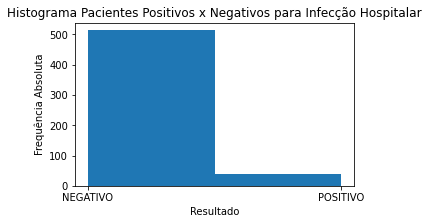


Lista pacientes com infecção:  (39, 2)
/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3


In [ ]:
df6 = df5.copy(deep=True)

def infec(x):
    '''
    Função para rotular exame Infecção(1) ou Não Infecção(0)
    '''
    #starting
    resultado = 0

    #Exame 1
    filtro_1 = ( x['Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais']=='POSITIVO')

    #Exame 2
    filtro_2 = ( x['Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais'] == 'POSITIVO')    

    #Exame 3
    filtro_3 = ( x['Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios'] == 'POSITIVO' )

    #Exame 4
    filtro_4 = ( x['Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios'] == 'POSITIVO' )

    #Exame 5
    filtro_5 = ( x['Fungos, Cultura.Fungos, Cultura'] == 'POSITIVO' )

    #Exame 6
    filtro_6 = ( x['Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos'] == 'POSITIVO' )

    #Garante que seja infecção hospitalar
    filtro_7 = ( x['PERIODO'] >= 3)

    #condicional
    if ( (filtro_1 or filtro_2 or filtro_3 or filtro_4 or filtro_5 or filtro_6) and filtro_7 ):
        resultado = 1
    else:
        resultado = 0

    return resultado

# cria coluna
df6['INFEC'] = np.nan

#chama covid()
df6['INFEC'] = df6.apply( lambda row : infec(row), axis = 1)

# fazendo agrupamento por PACIENTE, pois alguns pacientes fizeram mais de um exame
df_infec = df6.groupby( ['PACIENTE'] ).agg( { 'INFEC':['sum'] } ).reset_index()

#solucionando nome colunas dois niveis
df_infec.columns = [ '_'.join(x) for x in df_infec.columns ]
df_infec.columns=['PACIENTE', 'INFEC']
#df_infec.to_excel('df_infec.xlsx')

# prints
print("Positivo: ")
print(df_infec[df_infec['INFEC']>=1].shape)
print('\nNegativo: ')
print(df_infec[df_infec['INFEC']==0].shape, '\n')

# Alterando rotulo de 1 para 'POSITIVO' e de 0 para 'NEGATIVO'
# saida
def saida(x):
    #condicional
    if (x['INFEC']>0):
        resultado = 'POSITIVO'
    else:
        resultado = 'NEGATIVO'

    return resultado

#chama saida()
df_infec['INFEC'] = df_infec.apply( lambda row : saida(row), axis = 1)

# Histograma
plt.title('Histograma Pacientes Positivos x Negativos para Infecção Hospitalar')
plt.xlabel('Resultado')
plt.ylabel('Frequência Absoluta')
plt.hist(df_infec['INFEC'], bins=2, rwidth=1.4)
plt.gcf().set_size_inches(5, 3) # alterar tamanho
plt.rcParams.update({'font.size': 10})
plt.show()

# Gera planilha com pacientes positivos
lista_infec_positivo = df_infec[df_infec['INFEC']=='POSITIVO']
print("\nLista pacientes com infecção: ", lista_infec_positivo.shape)
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
lista_infec_positivo.to_excel('lista_infec_positivo.xlsx')

In [ ]:
df6

,PACIENTE,PERIODO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia,INFEC
0,004688799FD293C3ABE0A07209FD8B75,0.0,"0,21","0,15","0,36",DETECTADO (POSITIVO),"2,29",33,37,28,...,"0,5",9000,negativa,"1,50","inferior a 1,0 mg/dL","5,0",NaN,NaN,86,0
1,004688799FD293C3ABE0A07209FD8B75,1.0,NaN,NaN,NaN,NaN,"2,12",36,40,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,0
2,004688799FD293C3ABE0A07209FD8B75,2.0,NaN,NaN,NaN,NaN,"1,87",42,47,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62,0
3,004688799FD293C3ABE0A07209FD8B75,3.0,NaN,NaN,NaN,NaN,"1,95",40,44,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,0
4,004688799FD293C3ABE0A07209FD8B75,4.0,NaN,NaN,NaN,NaN,"1,86",42,47,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6792,FF4B2EED093AE641B9328FDB293C4116,9.0,NaN,NaN,NaN,NaN,"0,89",superior a 90,superior a 60,superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,0
6793,FF4B2EED093AE641B9328FDB293C4116,10.0,NaN,NaN,NaN,NaN,"0,97",superior a 90,superior a 60,superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,0
6794,FF4B2EED093AE641B9328FDB293C4116,61.0,NaN,NaN,NaN,NaN,"0,90",superior a 90,superior a 60,superior a 90,...,"inferior a 0,3 g/L",1000,negativa,"inferior a 0,10 g/L","inferior a 1,0 mg/dL","6,0",NEGATIVO,Parcial Negativo,28,0
6795,FF4B2EED093AE641B9328FDB293C4116,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
# Acessa diretório correto
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3

# Importa lista de planilha exportada anteriormente
df_pacientes_positivos = pd.read_excel('lista_infec_positivo.xlsx', sheet_name='Sheet1')

# Transforma coluna do dataframe Pandas em lista
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
Lista pacientes positivos:  39 



In [ ]:

# rotulando pacientes como POSITIVO ou NEGATIVO, para infecção

def def_infec(x):
    #condicional
    if (x['PACIENTE'] in lista_pacientes):
        resultado = 'POSITIVO'
    else:
        resultado = 'NEGATIVO'

    return resultado

#chama saida()
df6['INFEC'] = df6.apply( lambda row : def_infec(row), axis = 1)



## Adicionando desfecho

In [ ]:
inform_desfecho.columns = ['PACIENTE', 'DESFECHO']

inform_desfecho = inform_desfecho.groupby(['PACIENTE']).agg({'DESFECHO':['last']}).reset_index()

#solucionando nome colunas dois niveis
inform_desfecho.columns = [ '_'.join(x) for x in inform_desfecho.columns ]
inform_desfecho.columns=['PACIENTE', 'DESFECHO']

# Adiciona desfecho em cada paciente
df_final = df6.merge(inform_desfecho, on=['PACIENTE'], how='left')

In [ ]:
colunas = df_final.columns.to_list()
colunas

['PACIENTE',
 'PERIODO',
 'Bilirrubinas Total E Fracoes.Bilirrubina Direta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Indireta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Total',
 'COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente MDRD',
 'Creatinina.Creatinina',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Cálcio Ionizável.Calcio Ionizavel',
 'D. Dimeros(Dimeros De Fibrina).Dimeros D, quant',
 'Desidrogenase Lática (DHL/L).DHL',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Co

In [ ]:
# alterando a posição da coluna 'INFEC' e 'DESFECHO'
colunas = ['PACIENTE',
 'PERIODO',
 'INFEC',
 'DESFECHO',
 'Bilirrubinas Total E Fracoes.Bilirrubina Direta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Indireta',
 'Bilirrubinas Total E Fracoes.Bilirrubina Total',
 'COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente MDRD',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente CKD-EPI',
 'Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/não afrodescendente MDRD',
 'Creatinina.Creatinina',
 'Creatinofosfoquinase Cpk-Ck.CK',
 'Cálcio Ionizável.Calcio Ionizavel',
 'D. Dimeros(Dimeros De Fibrina).Dimeros D, quant',
 'Desidrogenase Lática (DHL/L).DHL',
 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)',
 'Ferritina, Dosagem.Ferritina',
 'Fibrinogênio, Dosagem Do.Fibrinogenio',
 'Fosfatase Alcalina.Fosfatase Alcalina',
 'Fungos, Cultura.Fungos, Cultura',
 'Fósforo.Fósforo',
 'Gama Gt.Gama-GT',
 'Gasometria Venosa.BE venoso',
 'Gasometria Venosa.HCO3 venoso',
 'Gasometria Venosa.Sat O2 venoso',
 'Gasometria Venosa.pCO2 venoso',
 'Gasometria Venosa.pH venoso',
 'Gasometria Venosa.pO2 venoso',
 'Glicemia, plasma.Glicose',
 'Hemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais',
 'Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais',
 'Hemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios',
 'Hemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios',
 'Hemocultura, para Fungos, Varios Materiais.Hemocultura Fungos',
 'Hemograma.Basófilos',
 'Hemograma.Basófilos (%)',
 'Hemograma.CHCM',
 'Hemograma.Eosinófilos',
 'Hemograma.Eosinófilos (%)',
 'Hemograma.Eritrócitos',
 'Hemograma.HCM',
 'Hemograma.Hematócrito',
 'Hemograma.Hemoglobina',
 'Hemograma.Leucócitos',
 'Hemograma.Linfócitos',
 'Hemograma.Linfócitos (%)',
 'Hemograma.Monócitos',
 'Hemograma.Monócitos (%)',
 'Hemograma.Morfologia, SB',
 'Hemograma.Morfologia, SVE',
 'Hemograma.Neutrófilos',
 'Hemograma.Neutrófilos (%)',
 'Hemograma.Plaquetas',
 'Hemograma.RDW',
 'Hemograma.VCM',
 'Hemograma.Volume plaquetário médio',
 'Lactato - Kit Urg.Lactato, sangue',
 'Lactato.Lactato, plasma',
 'Magnesio.Magnésio',
 'Peptideo Natriuretico Tipo B (Bnp).BNP',
 'Potássio.Potássio',
 'Proteína C Reativa, plasma.Proteína C-Reativa',
 'Pró-calcitonina, Dosagem no Plasma.Procalcitonina',
 'Sódio.Sódio',
 'Tempo E Ativid. Protrombina (Tp).TP/INR',
 'Tempo E Ativid. Protrombina (Tp).Tempo de Protrombina',
 'Tempo Tromb.Parcial Ativada.TTPA',
 'Tempo Tromb.Parcial Ativada.TTPA - Paciente/Normal',
 'Tempo Tromb.Parcial Ativada.TTPA-Normal do dia',
 'Tgo.AST (TGO)',
 'Tgp.ALT (TGP)',
 'Troponina.Troponina',
 'Tsh - Hormonio Tiroestimulante.TSH',
 'Urina Tipo I - Jato Medio.Aspecto, urina',
 'Urina Tipo I - Jato Medio.Bilirrubina,urina',
 'Urina Tipo I - Jato Medio.C.Cetônicos, urina',
 'Urina Tipo I - Jato Medio.Cilindros, urina',
 'Urina Tipo I - Jato Medio.Cor, urina',
 'Urina Tipo I - Jato Medio.Células Epiteliais',
 'Urina Tipo I - Jato Medio.Densidade, urina',
 'Urina Tipo I - Jato Medio.Eritrócitos, urina',
 'Urina Tipo I - Jato Medio.Glicose, urina isol',
 'Urina Tipo I - Jato Medio.Leucócitos, urina',
 'Urina Tipo I - Jato Medio.Nitrito, urina',
 'Urina Tipo I - Jato Medio.Proteínas, urina isolada',
 'Urina Tipo I - Jato Medio.Urobilinogênio,urina',
 'Urina Tipo I - Jato Medio.pH, urina',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Uréia.Uréia']

In [ ]:
df_final = df_final[colunas]

df_final.head(20)

,PACIENTE,PERIODO,INFEC,DESFECHO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
0,004688799FD293C3ABE0A07209FD8B75,0.0,NEGATIVO,Alta Administrativa,"0,21","0,15","0,36",DETECTADO (POSITIVO),"2,29",33,...,53000,"0,5",9000,negativa,"1,50","inferior a 1,0 mg/dL","5,0",NaN,NaN,86
1,004688799FD293C3ABE0A07209FD8B75,1.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,12",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91
2,004688799FD293C3ABE0A07209FD8B75,2.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"1,87",42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62
3,004688799FD293C3ABE0A07209FD8B75,3.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"1,95",40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63
4,004688799FD293C3ABE0A07209FD8B75,4.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"1,86",42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58
5,004688799FD293C3ABE0A07209FD8B75,5.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,02",38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
6,004688799FD293C3ABE0A07209FD8B75,6.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,18",35,...,3000,"inferior a 0,3 g/L",5000,negativa,"0,28","inferior a 1,0 mg/dL","5,0",NEGATIVO,Parcial Negativo,108
7,004688799FD293C3ABE0A07209FD8B75,7.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,38",31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135
8,004688799FD293C3ABE0A07209FD8B75,8.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,11",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116
9,004688799FD293C3ABE0A07209FD8B75,9.0,NEGATIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"2,13",36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110


In [ ]:
df_infec_positivo = df_final[df6["INFEC"]=='POSITIVO']

df_infec_positivo["PACIENTE"].nunique()

39

In [ ]:
%cd /content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3
df_final.to_excel('resultados_geral.xlsx')
df_infec_positivo.to_excel('resultados_somente_positivos.xlsx')

/content/drive/Shareddrives/Analise_Dr_Paulo_Abrao/Relatorio_3


## Verificando desfecho dos pacientes positivos

In [ ]:
df_infec_positivo.head(3)

,PACIENTE,PERIODO,INFEC,DESFECHO,Bilirrubinas Total E Fracoes.Bilirrubina Direta,Bilirrubinas Total E Fracoes.Bilirrubina Indireta,Bilirrubinas Total E Fracoes.Bilirrubina Total,"COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Creatinina","Calculo da Estimativa da Taxa, de Filtracao Glomular, soro.Cálculo p/afrodescendente CKD-EPI",...,"Urina Tipo I - Jato Medio.Eritrócitos, urina","Urina Tipo I - Jato Medio.Glicose, urina isol","Urina Tipo I - Jato Medio.Leucócitos, urina","Urina Tipo I - Jato Medio.Nitrito, urina","Urina Tipo I - Jato Medio.Proteínas, urina isolada","Urina Tipo I - Jato Medio.Urobilinogênio,urina","Urina Tipo I - Jato Medio.pH, urina","Urina, Cultura - Jato Médio.Cultura de Urina","Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial",Uréia.Uréia
155,05A90EA98B6F86A86FA06EDB1616BB61,0.0,POSITIVO,Alta Administrativa,NaN,NaN,NaN,DETECTADO,"0,85",superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
156,05A90EA98B6F86A86FA06EDB1616BB61,1.0,POSITIVO,Alta Administrativa,NaN,NaN,NaN,NaN,"0,80",superior a 90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
157,05A90EA98B6F86A86FA06EDB1616BB61,2.0,POSITIVO,Alta Administrativa,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_grupos = df_infec_positivo[["PACIENTE", "DESFECHO"]]

grupos = df_grupos.groupby(["PACIENTE"]).agg( {"DESFECHO" :['last']}).reset_index()

#solucionando nome colunas dois niveis
grupos.columns = [ '_'.join(x) for x in grupos.columns ]
grupos.columns=['PACIENTE', 'DESFECHO']

grupos["DESFECHO"].value_counts()

# número de óbitos = 15 em 39

Alta médica melhorado                                               13
Alta Administrativa                                                 10
Óbito após 48hs de internação sem necrópsia                         10
Óbito nas primeiras 48hs de internação sem necrópsia não agônico     3
Desistência do atendimento                                           1
Óbito após 48hs de internação com necrópsia                          1
Óbito nas primeiras 48hs de internação sem necrópsia agônico         1
Name: DESFECHO, dtype: int64




























## Gerando lista de pacientes positivos

In [ ]:
grupos.shape

(39, 2)

In [ ]:
pacientes_positivos = grupos["PACIENTE"]

pacientes_positivos.shape

pacientes_positivos.to_excel("pacientes_positivos.xlsx")

## Gerando lista de pacientes negativos

In [ ]:
pacientes_negativos = df_final[df_final["INFEC"]=="NEGATIVO"]

pacientes_negativos = pacientes_negativos["PACIENTE"].unique()

pacientes_negativos.shape

(513,)

In [ ]:
pacientes_negativos = pd.DataFrame(pacientes_negativos)

pacientes_negativos.to_excel("pacientes_negativos.xlsx")